Notebook to analyse the relation of the decision to adopt or not SBP in each municipality in each year with the various features, for all municipalities and years (with adoption or not).

1st step of the double hurdle model.

# Content
* Data ingestion
* Data first exploration
* Features analysis
    * Variance analysis
    * Correlation - Spearman rho and correlation matrices
        * All years
        * Restricted to PCF years (and comparison)
        * Low correlations
        * Census features combinations
* Multicollinearity analysis (VIF)
    * With census features combined and not

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
path_to_final_dataset = "Municipalities final dataset for analysis.csv"

In [4]:
# How to display floats
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=6)

# Data ingestion

In [5]:
dataset_original = pd.read_csv(path_to_final_dataset, index_col=['Municipality', 'Year'])

### Transform the label into 1/0 for adoption yes/no

In [6]:
dataset_original['adoption_in_year'] = dataset_original['adoption_in_year'].apply(lambda x: 1 if x > 0.0000001 else 0)

In [7]:
dataset = dataset_original.reset_index(drop=True)

In [8]:
dataset.head(2)

,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.938,685.085,289.653,68.951,11.578,15.374,1.327,6.903,5.697,0.000
1,1,0.060,0.060,0.060,0.003,0.003,0.003,0.004,0.004,0.004,...,0.938,685.085,289.653,68.951,11.578,15.374,1.327,6.903,5.697,0.000


In [9]:
dataset.columns

Index(['adoption_in_year', 'adoption_pr_y_munic',
       'tot_cumul_adoption_pr_y_munic', 'cumul_adoption_10_y_pr_y_munic',
       'adoption_pr_y_neighbours_adj',
       'tot_cumul_adoption_pr_y_neighbours_adj',
       'cumul_adoption_10_y_pr_y_neighbours_adj',
       'adoption_pr_y_neighbours_10km',
       'tot_cumul_adoption_pr_y_neighbours_10km',
       'cumul_adoption_10_y_pr_y_neighbours_10km',
       'adoption_pr_y_neighbours_20km',
       'tot_cumul_adoption_pr_y_neighbours_20km',
       'cumul_adoption_10_y_pr_y_neighbours_20km',
       'adoption_pr_y_neighbours_40km',
       'tot_cumul_adoption_pr_y_neighbours_40km',
       'cumul_adoption_10_y_pr_y_neighbours_40km',
       'adoption_pr_y_neighbours_60km',
       'tot_cumul_adoption_pr_y_neighbours_60km',
       'cumul_adoption_10_y_pr_y_neighbours_60km',
       'adoption_pr_y_neighbours_80km',
       'tot_cumul_adoption_pr_y_neighbours_80km',
       'cumul_adoption_10_y_pr_y_neighbours_80km', 'adoption_pr_y_port',
       'tot

## Organise features by categorical/numerical and by topic

In [10]:
label = ['adoption_in_year']

In [11]:
features_list = [col for col in dataset.columns if col != 'adoption_in_year']
features = pd.DataFrame(index=dataset.columns, columns=['num/cat', 'topic'])

In [12]:
adoption_features = [feat for feat in features.index if 'adoption' in feat and feat not in label]
features.loc[adoption_features, :] = ['num', 'SBP_adoption']

In [13]:
climate_features = [feat for feat in features.index if '_t_' in feat or '_prec_' in feat]
features.loc[climate_features, :] = ['num', 'climate']

In [14]:
soil_features = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features.loc[soil_features, :] = ['num', 'soil']

In [15]:
economic_features = ['sbp_payment']
features.loc[economic_features, :] = ['num', 'economic']

In [16]:
features_not_census = adoption_features + climate_features + soil_features + economic_features
census_features = [feat for feat in features_list if feat not in features_not_census]
features.loc[census_features, :] = ['num', 'census']

# First exploration

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4403 entries, 0 to 4402
Data columns (total 86 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   adoption_in_year                          4403 non-null   int64  
 1   adoption_pr_y_munic                       4403 non-null   float64
 2   tot_cumul_adoption_pr_y_munic             4403 non-null   float64
 3   cumul_adoption_10_y_pr_y_munic            4403 non-null   float64
 4   adoption_pr_y_neighbours_adj              4403 non-null   float64
 5   tot_cumul_adoption_pr_y_neighbours_adj    4403 non-null   float64
 6   cumul_adoption_10_y_pr_y_neighbours_adj   4403 non-null   float64
 7   adoption_pr_y_neighbours_10km             4403 non-null   float64
 8   tot_cumul_adoption_pr_y_neighbours_10km   4403 non-null   float64
 9   cumul_adoption_10_y_pr_y_neighbours_10km  4403 non-null   float64
 10  adoption_pr_y_neighbours_20km       

In [18]:
dataset.describe()

,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,...,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000,4403.000
mean,0.513,0.003,0.022,0.020,0.004,0.026,0.024,0.004,0.028,0.025,...,9.859,826.762,279.695,58.090,22.512,14.401,1.703,17.839,5.731,32.477
std,0.500,0.009,0.053,0.047,0.007,0.047,0.041,0.006,0.044,0.038,...,10.948,238.499,13.575,11.581,22.710,2.234,0.464,7.127,0.511,58.732
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.023,482.106,235.396,29.521,0.859,10.109,0.565,1.365,4.923,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.002,0.002,...,0.688,626.730,274.510,49.945,6.849,12.497,1.385,12.426,5.270,0.000
50%,1.000,0.000,0.003,0.003,0.001,0.007,0.007,0.001,0.009,0.009,...,5.261,797.115,281.243,56.633,14.573,14.764,1.596,17.509,5.648,0.000
75%,1.000,0.003,0.025,0.022,0.004,0.031,0.030,0.005,0.035,0.034,...,15.750,943.952,288.333,65.750,28.507,16.355,2.105,22.591,6.089,0.000
max,1.000,0.210,0.682,0.584,0.164,0.518,0.413,0.061,0.418,0.281,...,46.175,1573.570,301.375,83.458,118.233,19.020,3.443,41.665,7.009,153.260


## Explore label

In [19]:
dataset[label].value_counts()

adoption_in_year
1                   2259
0                   2144
dtype: int64

array([[<AxesSubplot:title={'center':'adoption_pr_y_munic'}>,
        <AxesSubplot:title={'center':'tot_cumul_adoption_pr_y_munic'}>,
        <AxesSubplot:title={'center':'cumul_adoption_10_y_pr_y_munic'}>,
        <AxesSubplot:title={'center':'adoption_pr_y_neighbours_adj'}>,
        <AxesSubplot:title={'center':'tot_cumul_adoption_pr_y_neighbours_adj'}>],
       [<AxesSubplot:title={'center':'cumul_adoption_10_y_pr_y_neighbours_adj'}>,
        <AxesSubplot:title={'center':'adoption_pr_y_neighbours_10km'}>,
        <AxesSubplot:title={'center':'tot_cumul_adoption_pr_y_neighbours_10km'}>,
        <AxesSubplot:title={'center':'cumul_adoption_10_y_pr_y_neighbours_10km'}>,
        <AxesSubplot:title={'center':'adoption_pr_y_neighbours_20km'}>],
       [<AxesSubplot:title={'center':'tot_cumul_adoption_pr_y_neighbours_20km'}>,
        <AxesSubplot:title={'center':'cumul_adoption_10_y_pr_y_neighbours_20km'}>,
        <AxesSubplot:title={'center':'adoption_pr_y_neighbours_40km'}>,
        <Ax

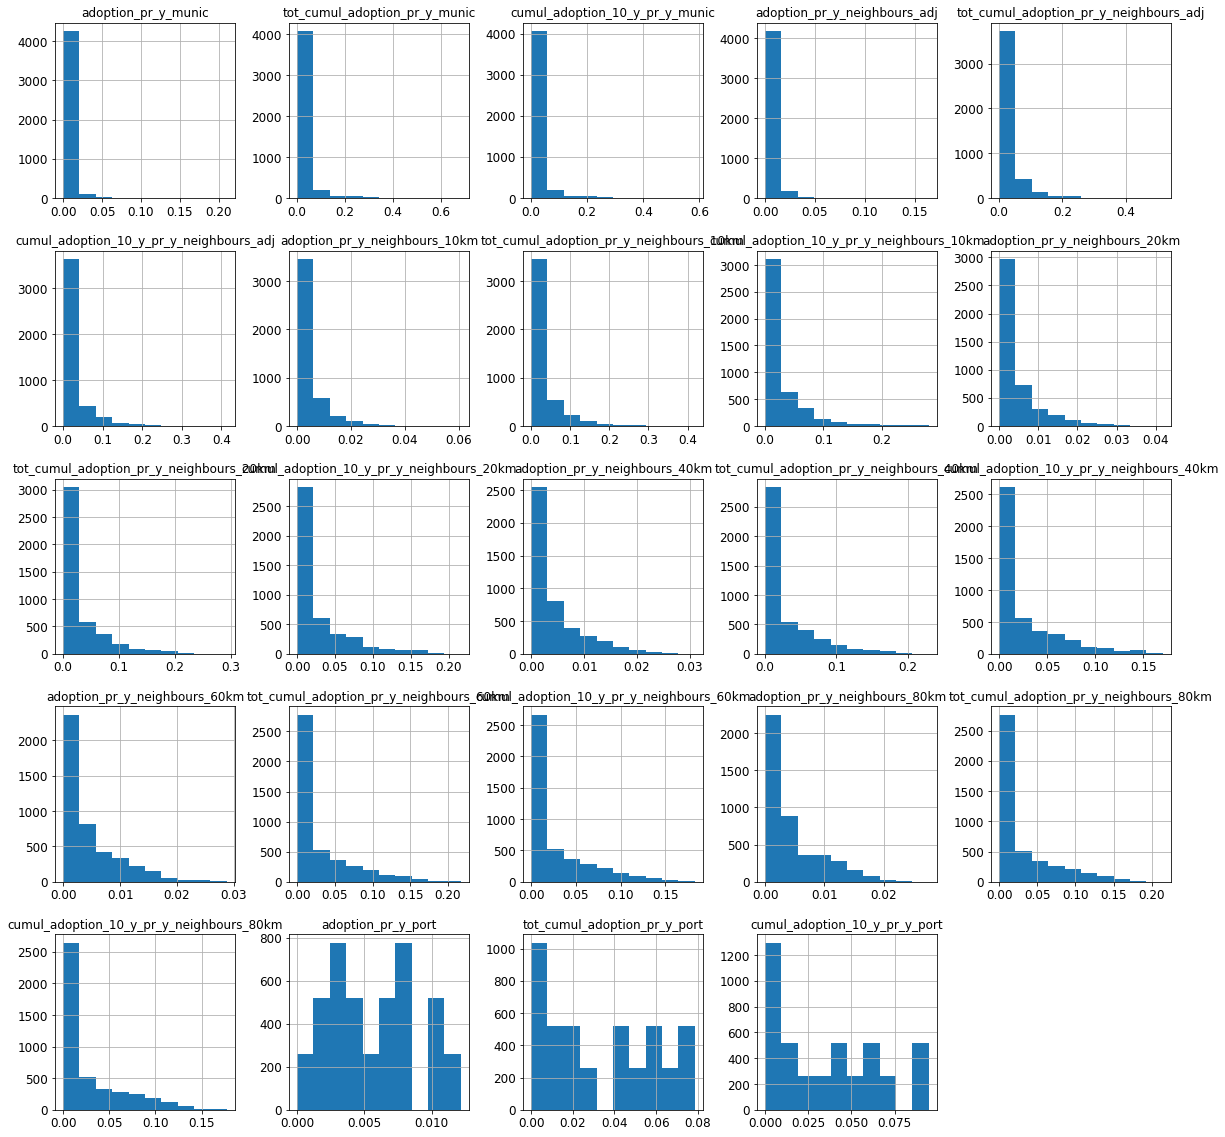

In [20]:
adoption_features = features.loc[features['topic'] == 'SBP_adoption'].index.tolist()
dataset[adoption_features].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'individual_prod_num'}>,
        <AxesSubplot:title={'center':'individual_prod_autonomous'}>,
        <AxesSubplot:title={'center':'individual_prod_in_business'}>,
        <AxesSubplot:title={'center':'educ_cannot_read_write'}>,
        <AxesSubplot:title={'center':'educ_can_read_write'}>,
        <AxesSubplot:title={'center':'educ_basic_1st_cycle'}>],
       [<AxesSubplot:title={'center':'educ_basic_2nd_cycle'}>,
        <AxesSubplot:title={'center':'educ_basic_3rd_cycle'}>,
        <AxesSubplot:title={'center':'educ_secondary_agr'}>,
        <AxesSubplot:title={'center':'educ_secondary_not_agr'}>,
        <AxesSubplot:title={'center':'educ_polyt_or_superior_agr'}>,
        <AxesSubplot:title={'center':'educ_polyt_or_superior_not_agr'}>],
       [<AxesSubplot:title={'center':'prof_only_practical'}>,
        <AxesSubplot:title={'center':'prof_short'}>,
        <AxesSubplot:title={'center':'prof_long'}>,
        <AxesSubplot:title={'center':'prof_sho

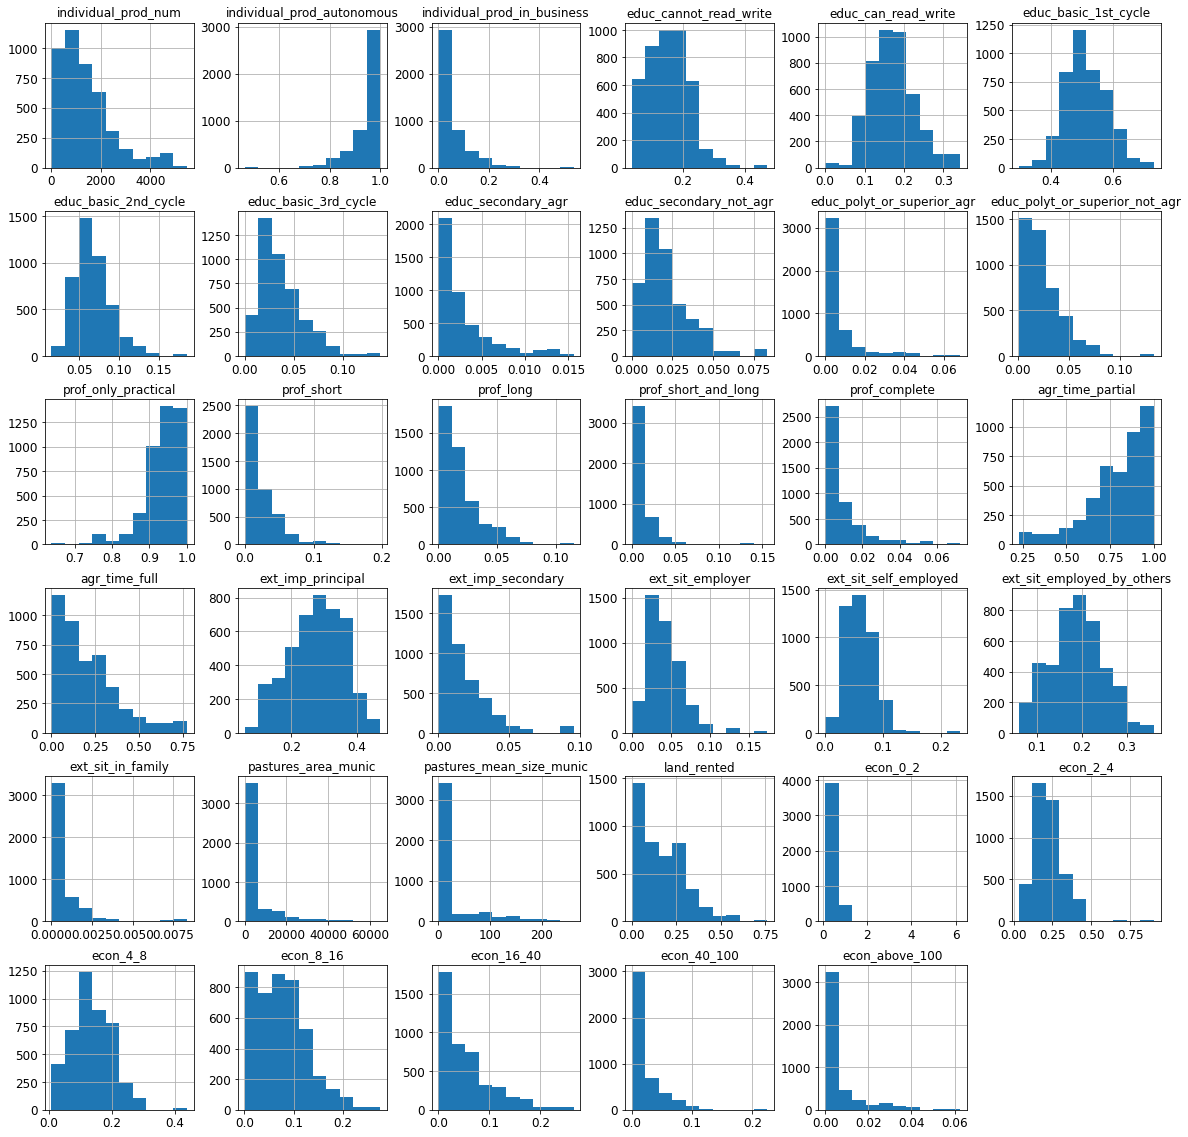

In [21]:
census_features = features.loc[(features['topic'] == 'census')].index.tolist()
dataset[census_features].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'av_d_mean_t_pr_y_munic'}>,
        <AxesSubplot:title={'center':'days_mean_t_over_20_pr_y_munic'}>,
        <AxesSubplot:title={'center':'days_mean_t_over_25_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_d_max_t_pr_y_munic'}>],
       [<AxesSubplot:title={'center':'days_max_t_over_30_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_d_min_t_pr_y_munic'}>,
        <AxesSubplot:title={'center':'days_min_t_under_0_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_prec_sum_pr_y_munic'}>],
       [<AxesSubplot:title={'center':'days_no_prec_pr_y_munic'}>,
        <AxesSubplot:title={'center':'cons_days_no_prec_pr_y_munic'}>,
        <AxesSubplot:title={'center':'av_d_mean_t_average_munic'}>,
        <AxesSubplot:title={'center':'days_mean_t_over_20_average_munic'}>],
       [<AxesSubplot:title={'center':'days_mean_t_over_25_average_munic'}>,
        <AxesSubplot:title={'center':'av_d_max_t_average_munic'}>,
        <AxesSubplot:titl

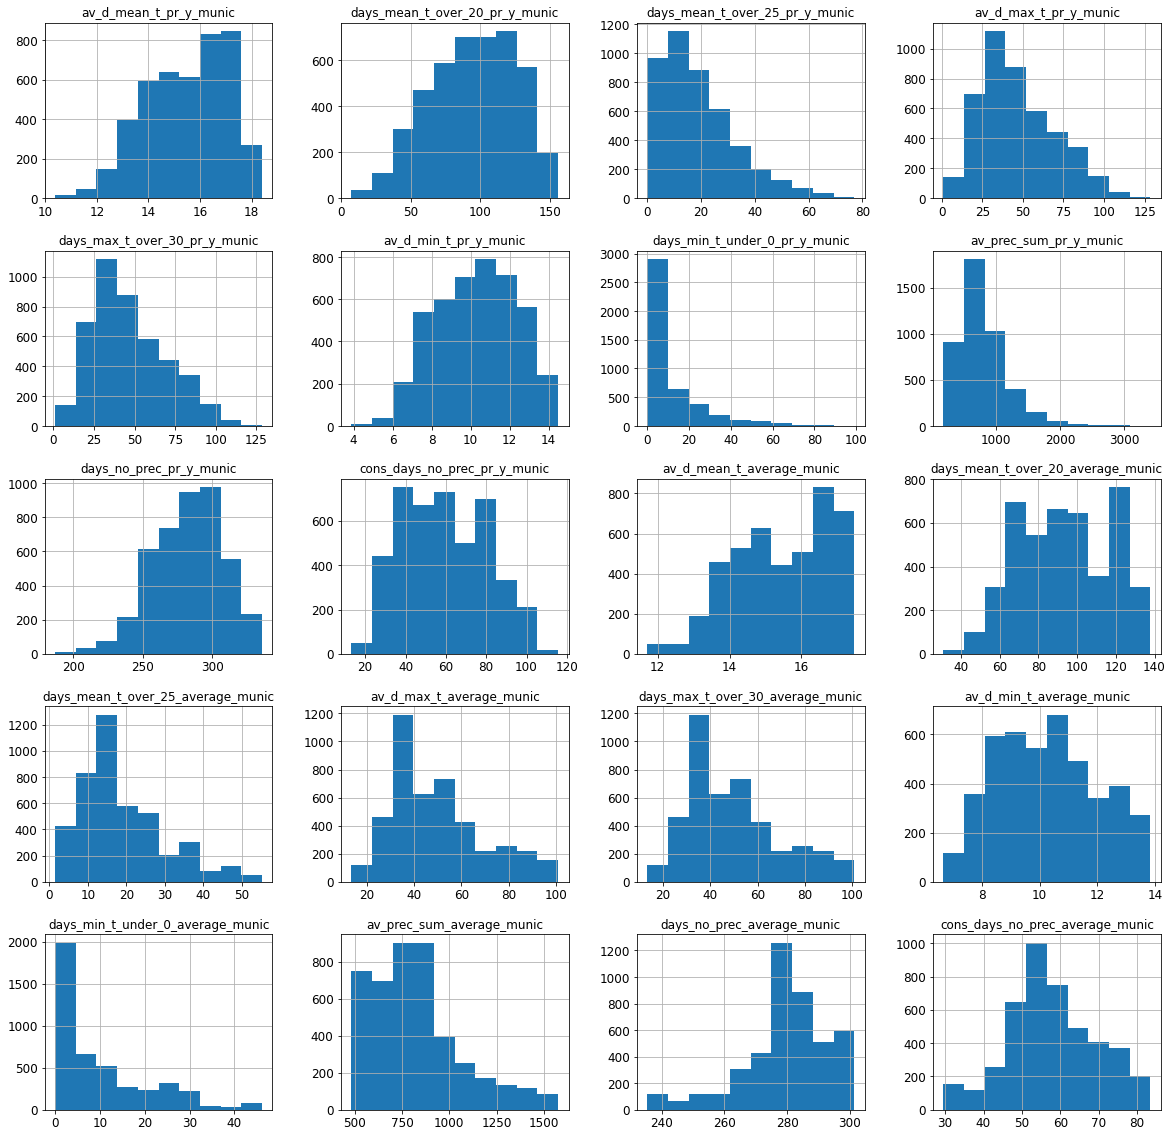

In [22]:
climate_features = features.loc[features['topic'] == 'climate'].index.tolist()
dataset[climate_features].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'CaCO3_mean_munic'}>,
        <AxesSubplot:title={'center':'CN_mean_munic'}>],
       [<AxesSubplot:title={'center':'N_mean_munic'}>,
        <AxesSubplot:title={'center':'P_mean_munic'}>],
       [<AxesSubplot:title={'center':'pH_mean_munic'}>, <AxesSubplot:>]],
      dtype=object)

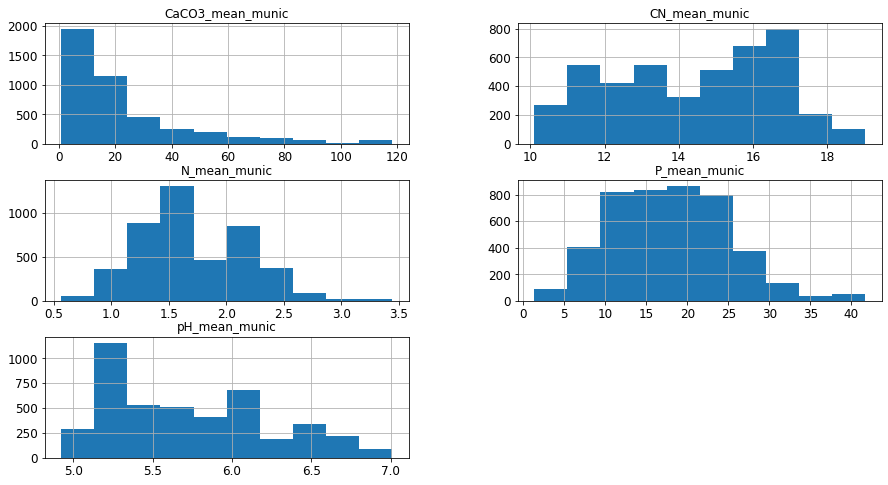

In [23]:
soil_features = features.loc[features['topic'] == 'soil'].index.tolist()
dataset[soil_features].hist(figsize=(15, 8))

In [24]:
features_num = features.loc[features['num/cat'] == 'num'].index.tolist()

# Features analysis

## Variance analysis

In [25]:
var = (dataset.describe().loc['std'] / dataset.describe().loc['mean'])
var.sort_values(ascending=True)

days_no_prec_average_munic       0.049
prof_only_practical              0.054
individual_prod_autonomous       0.066
av_d_mean_t_average_munic        0.086
days_no_prec_pr_y_munic          0.089
                                  ... 
pastures_area_munic              1.896
ext_sit_in_family                1.982
cumul_adoption_10_y_pr_y_munic   2.324
tot_cumul_adoption_pr_y_munic    2.453
adoption_pr_y_munic              2.828
Length: 86, dtype: float64

In [26]:
any(var < 0.01)

False

## Correlation analysis - Spearman rho and matrices

### All years

In [27]:
from scipy.stats import spearmanr

def get_spearmanr_results(features):
    results = pd.DataFrame(index=features, columns=['spearman r'])

    for (columnName, columnData) in dataset[features].iteritems():
        coef, p = spearmanr(columnData, dataset['adoption_in_year'])
        results.loc[columnName] = coef
    return results

In [28]:
spearman_results = get_spearmanr_results(features_num)

In [29]:
spearman_results.loc[adoption_features, :].sort_values('spearman r', ascending=False)

,spearman r
adoption_pr_y_munic,0.713
cumul_adoption_10_y_pr_y_munic,0.531
tot_cumul_adoption_pr_y_munic,0.520
adoption_pr_y_neighbours_adj,0.366
adoption_pr_y_neighbours_10km,0.309
adoption_pr_y_neighbours_20km,0.263
adoption_pr_y_neighbours_40km,0.223
adoption_pr_y_neighbours_60km,0.193
adoption_pr_y_neighbours_80km,0.165
cumul_adoption_10_y_pr_y_neighbours_adj,0.152


Here, the most important thing looks like being the adoption in the previous year

In [30]:
spearman_results.loc[census_features, :].sort_values('spearman r', ascending=False)

,spearman r
pastures_area_munic,0.258
pastures_mean_size_munic,0.237
econ_above_100,0.209
educ_polyt_or_superior_agr,0.143
individual_prod_in_business,0.130
econ_0_2,0.128
econ_40_100,0.121
prof_complete,0.114
ext_sit_employed_by_others,0.113
educ_secondary_not_agr,0.112


Here, pastures_area_munic should not be so particularly influenced since we just care if adopted or not and not the amount.

In [31]:
spearman_results.loc[climate_features, :].sort_values('spearman r', ascending=False)

,spearman r
cons_days_no_prec_average_munic,0.267
days_max_t_over_30_average_munic,0.240
av_d_max_t_average_munic,0.240
days_mean_t_over_25_average_munic,0.210
days_mean_t_over_20_average_munic,0.197
av_d_max_t_pr_y_munic,0.185
days_max_t_over_30_pr_y_munic,0.185
cons_days_no_prec_pr_y_munic,0.182
days_no_prec_average_munic,0.182
av_d_mean_t_average_munic,0.179


In [32]:
spearman_results.loc[soil_features, :].sort_values('spearman r', ascending=False)

,spearman r
pH_mean_munic,0.035
N_mean_munic,-0.024
CN_mean_munic,-0.088
CaCO3_mean_munic,-0.114
P_mean_munic,-0.137


In [33]:
economic_features = features.loc[(features['topic'] == 'economic')].index.tolist()
spearman_results.loc[economic_features, :].sort_values('spearman r', ascending=False)

,spearman r
sbp_payment,-0.335


Interesting and weird results, really high and negative correlation... to explain

#### Corrrelation matrix to spot also relation among the features

In [34]:
corr_matrix_sp = dataset.corr(method='spearman').round(decimals=2)

In [35]:
def plot_correlation_heatmap(matrix, size=(20, 20)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=range(len(matrix.index)), ticklabels=matrix.index)
    plt.xticks(rotation=90)
    ax.yaxis.set(ticks=range(len(matrix.columns)), ticklabels=matrix.columns)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            ax.text(j, i, matrix.iloc[i, j], ha='center', va='center',
                    color='r')
    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()

In [36]:
climate_features_average = [feat for feat in climate_features if 'average' in feat]

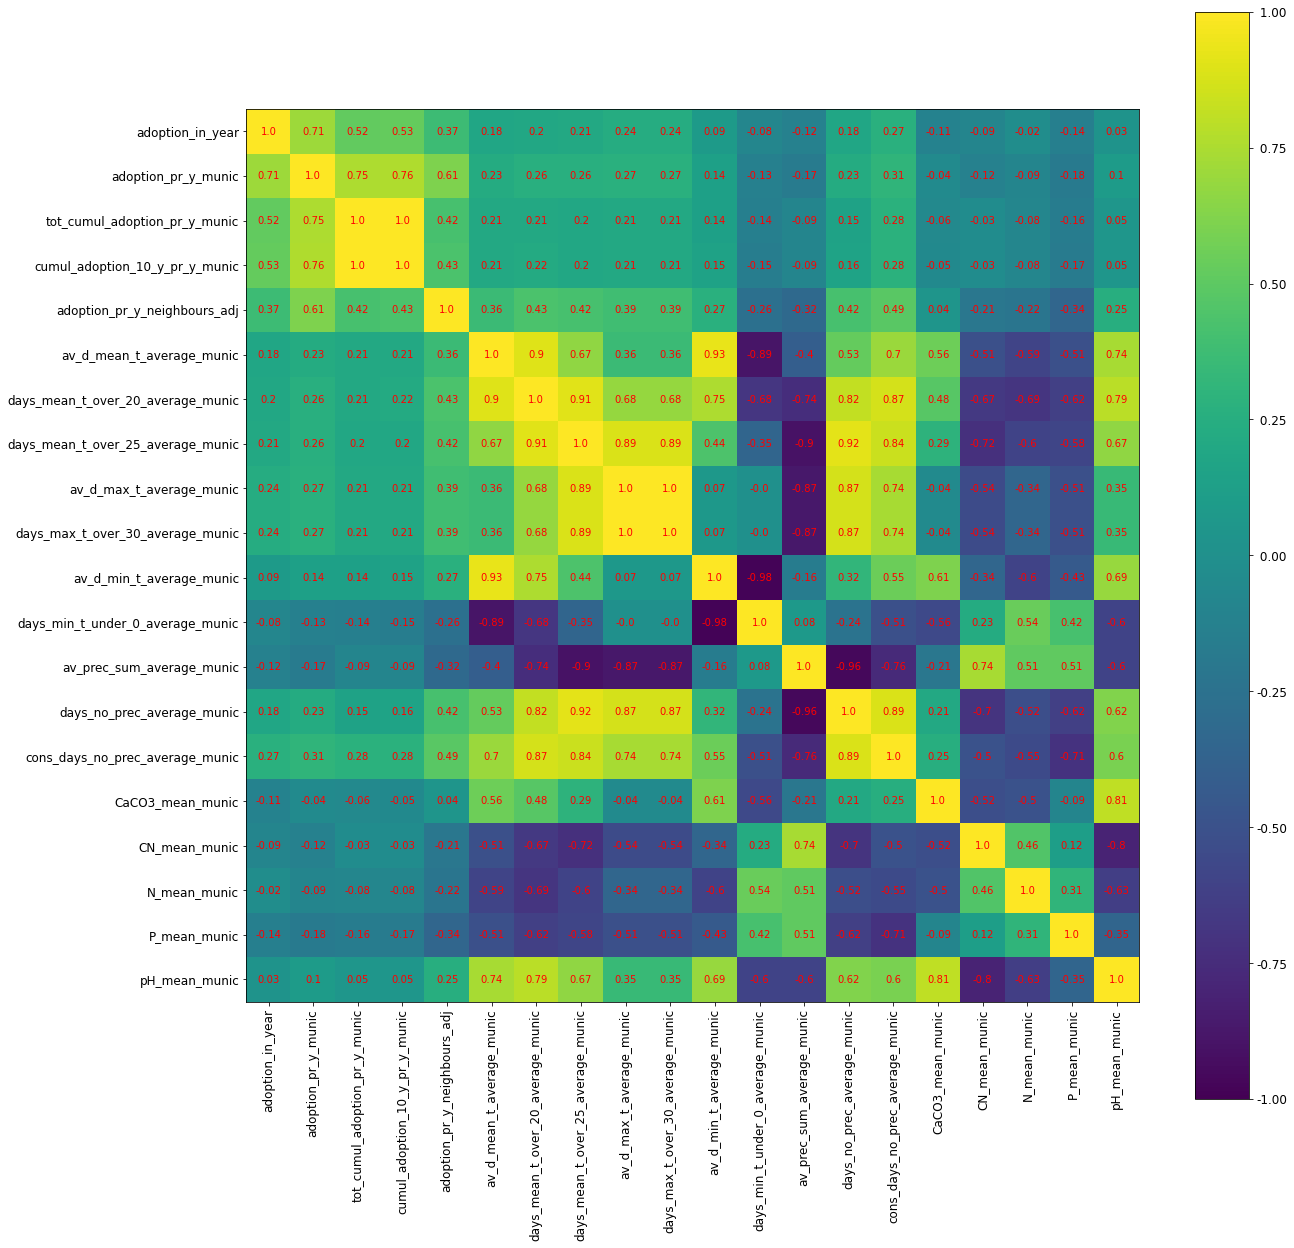

In [37]:
features_to_show = label + adoption_features[:4] + climate_features_average + soil_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Correlation on adoption

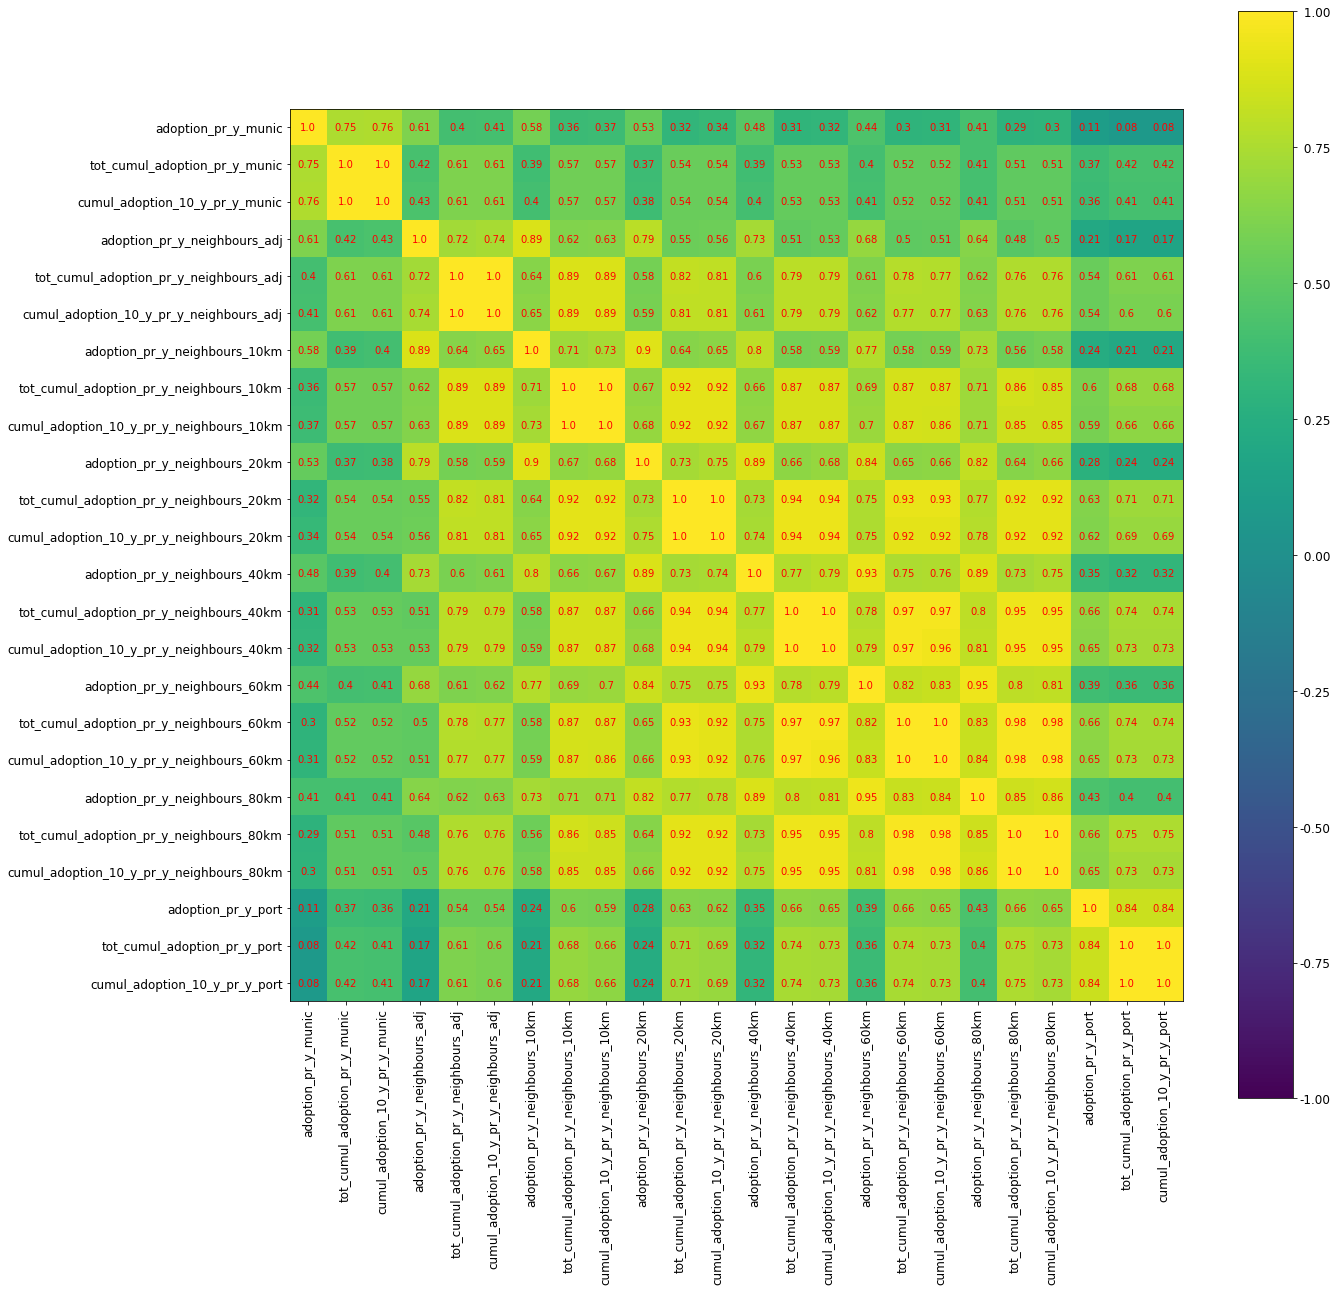

In [38]:
features_to_show = adoption_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Correlation on census features

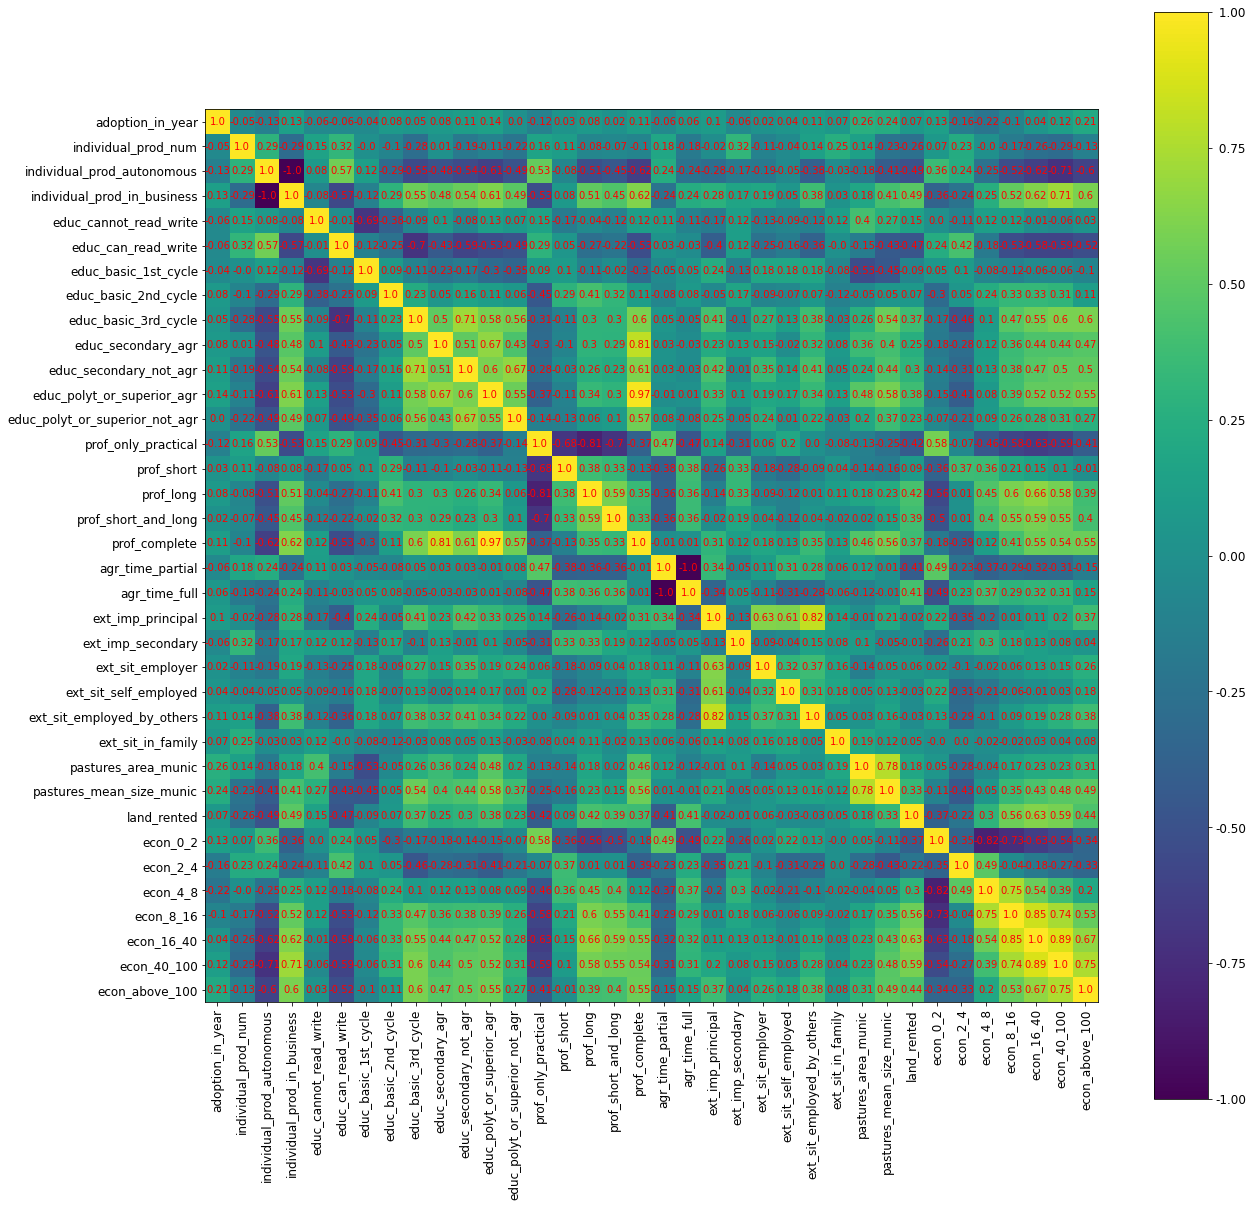

In [39]:
features_to_show = label + census_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

Correlation on environmental data

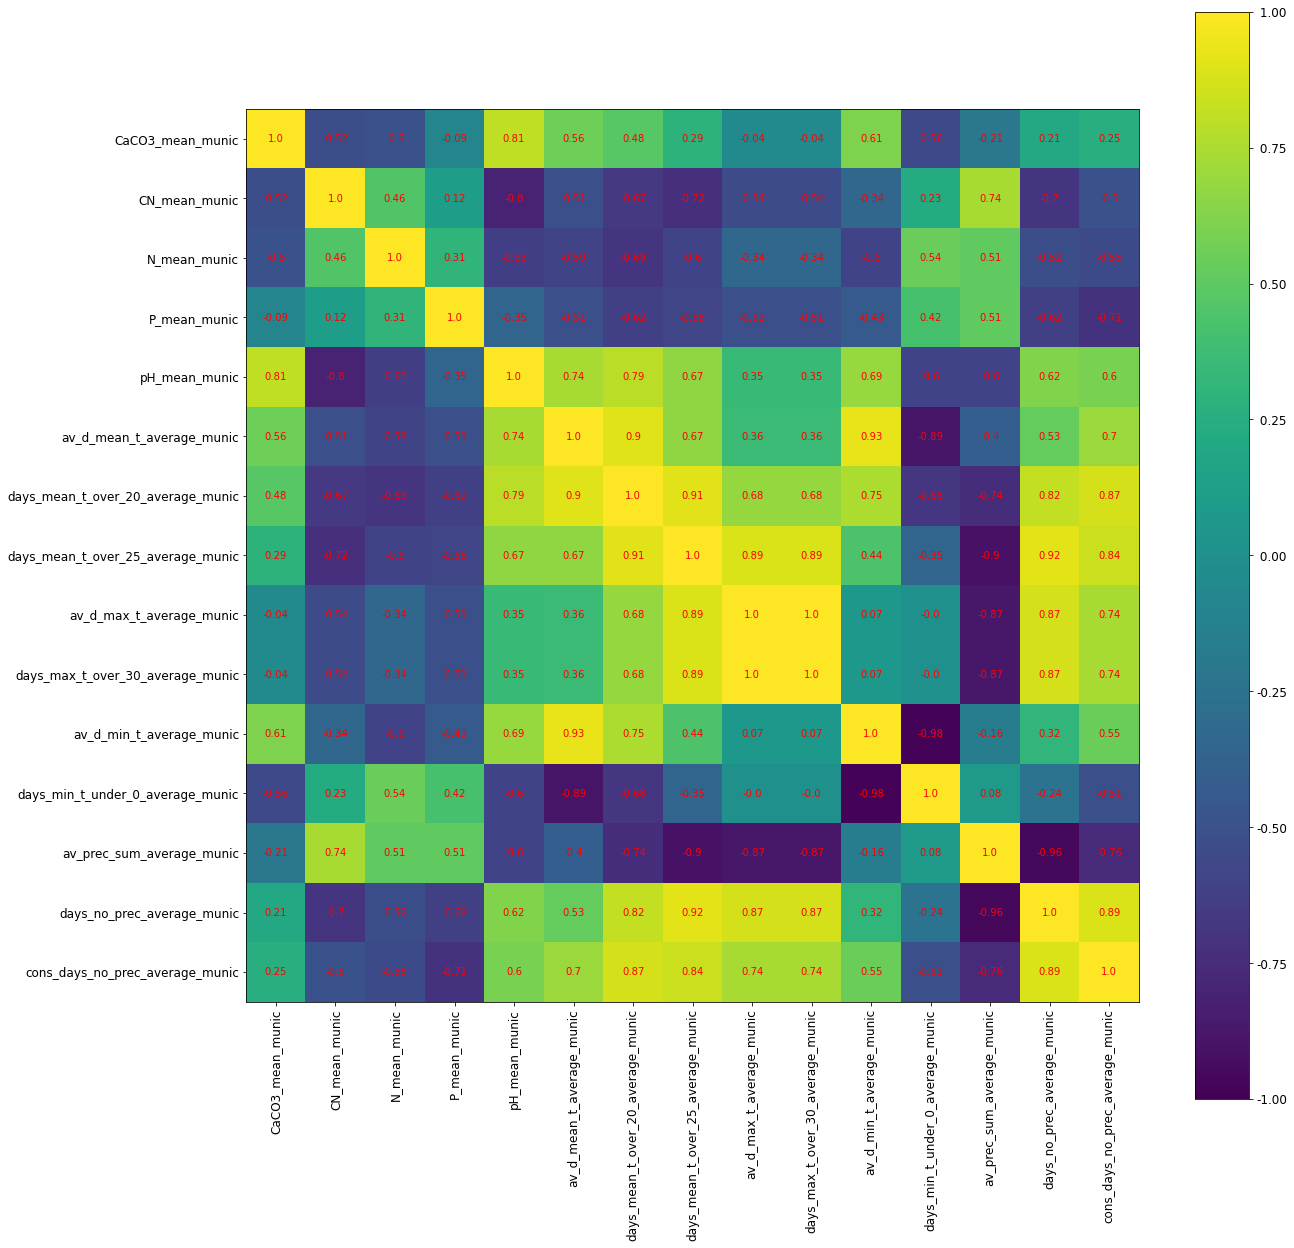

In [40]:
features_to_show = soil_features + climate_features_average
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

In [41]:
features_cat = features.loc[features['num/cat'] == 'cat'].index.tolist()

### Restricted to PCF years (and comparison)

In [42]:
dataset_PCF = dataset_original.loc[(slice(None), [2009, 2010, 2011, 2012]), :]

**Note:** the inclusion of 2009 makes the correlation regarding adoption in the previous year nor right, since it takes in to consideration values from 2008 that are disaggregated.

If 2009 not considered, it's correlation would be much higher! At 0.79. But it also makes sense also just because there are a lot of 0s that remains as such. In fact, if we look at the results in the 2nd part that does not consider 0s it is much lower the correlation.

The historical adoption has the same problem.

In [43]:
dataset_PCF = dataset_PCF.reset_index(drop=True)

In [44]:
dataset_PCF.shape

(1036, 86)

In [45]:
dataset_PCF.describe()

,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,...,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000,1036.000
mean,0.208,0.004,0.048,0.041,0.005,0.056,0.048,0.005,0.059,0.051,...,9.859,826.762,279.695,58.090,22.512,14.401,1.703,17.839,5.731,138.028
std,0.406,0.013,0.081,0.066,0.009,0.067,0.053,0.007,0.061,0.049,...,10.952,238.587,13.580,11.585,22.719,2.235,0.464,7.130,0.511,9.392
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.023,482.106,235.396,29.521,0.859,10.109,0.565,1.365,4.923,128.790
25%,0.000,0.000,0.000,0.000,0.000,0.014,0.011,0.000,0.014,0.013,...,0.688,626.730,274.510,49.945,6.849,12.497,1.385,12.426,5.270,131.272
50%,0.000,0.000,0.026,0.021,0.000,0.038,0.034,0.001,0.044,0.039,...,5.261,797.115,281.243,56.633,14.573,14.764,1.596,17.509,5.648,135.030
75%,0.000,0.002,0.049,0.043,0.007,0.079,0.071,0.008,0.085,0.077,...,15.750,943.952,288.333,65.750,28.507,16.355,2.105,22.591,6.089,141.785
max,1.000,0.210,0.682,0.569,0.164,0.518,0.403,0.061,0.418,0.272,...,46.175,1573.570,301.375,83.458,118.233,19.020,3.443,41.665,7.009,153.260


In [46]:
from scipy.stats import spearmanr

spearman_results_PCF = pd.DataFrame(index=features_num, columns=['spearman r only PCF'])

for (columnName, columnData) in dataset_PCF[features_num].iteritems():
    coef, p = spearmanr(columnData, dataset_PCF['adoption_in_year'])
    spearman_results_PCF.loc[columnName] = coef

In [47]:
# Merge with spearman rho results with all to compare
spearman_results_both = pd.concat([spearman_results_PCF, spearman_results], axis=1)
spearman_results_both.head()

,spearman r only PCF,spearman r
adoption_pr_y_munic,0.617,0.713
tot_cumul_adoption_pr_y_munic,0.477,0.520
cumul_adoption_10_y_pr_y_munic,0.467,0.531
adoption_pr_y_neighbours_adj,0.543,0.366
tot_cumul_adoption_pr_y_neighbours_adj,0.447,0.142


In [48]:
spearman_results_both.loc[adoption_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
adoption_pr_y_munic,0.617,0.713
adoption_pr_y_neighbours_adj,0.543,0.366
adoption_pr_y_neighbours_10km,0.527,0.309
adoption_pr_y_neighbours_20km,0.501,0.263
adoption_pr_y_neighbours_40km,0.489,0.223
tot_cumul_adoption_pr_y_munic,0.477,0.520
adoption_pr_y_neighbours_60km,0.472,0.193
cumul_adoption_10_y_pr_y_munic,0.467,0.531
adoption_pr_y_neighbours_80km,0.450,0.165
tot_cumul_adoption_pr_y_neighbours_adj,0.447,0.142


In [49]:
spearman_results_both.loc[census_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
pastures_mean_size_munic,0.613,0.237
pastures_area_munic,0.609,0.258
educ_polyt_or_superior_agr,0.506,0.143
prof_complete,0.496,0.114
econ_above_100,0.481,0.209
econ_40_100,0.444,0.121
educ_secondary_not_agr,0.438,0.112
educ_basic_3rd_cycle,0.428,0.054
educ_secondary_agr,0.405,0.084
econ_16_40,0.371,0.044


* First, the average pasture size
* Education features are really important (scholastic education but also agricultural training).
* Then, it comes if it's an empresario/autonomo and patrao/empregador
* Principale/secundaria (actividades remuneradas) instead not so relevant

mean_pastures_size_munic remains an interesting feature! pastures_area_munic increases, interesting since here there is no bias as before where we split based on that!

In [50]:
spearman_results_both.loc[climate_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
days_mean_t_over_25_average_munic,0.624,0.210
days_no_prec_average_munic,0.620,0.182
cons_days_no_prec_average_munic,0.603,0.267
days_max_t_over_30_average_munic,0.601,0.240
av_d_max_t_average_munic,0.601,0.240
days_mean_t_over_20_average_munic,0.580,0.197
av_d_max_t_pr_y_munic,0.528,0.185
days_max_t_over_30_pr_y_munic,0.528,0.185
days_mean_t_over_20_pr_y_munic,0.491,0.065
days_mean_t_over_25_pr_y_munic,0.488,0.129


In [51]:
spearman_results_both.loc[soil_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
pH_mean_munic,0.387,0.035
CaCO3_mean_munic,0.056,-0.114
N_mean_munic,-0.218,-0.024
P_mean_munic,-0.356,-0.137
CN_mean_munic,-0.530,-0.088


In [52]:
spearman_results_both.loc[economic_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
sbp_payment,0.012,-0.335


Here it makes sense that it's almost 0, since the payments are not changing much during the project

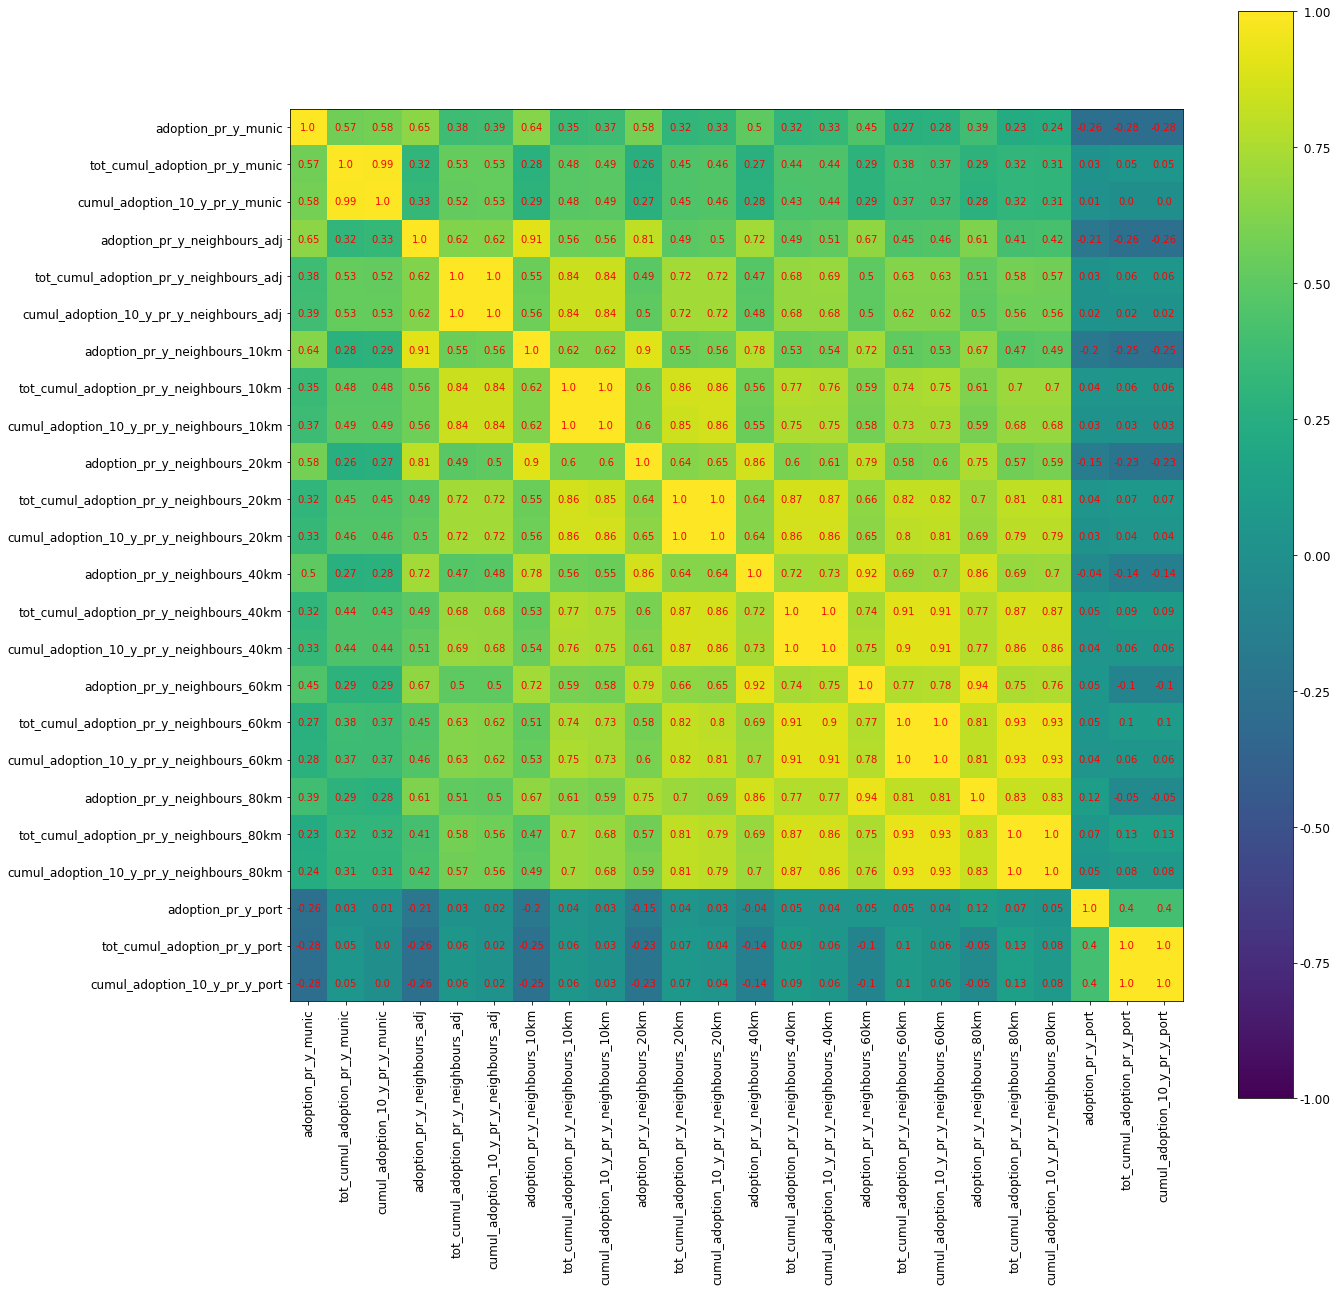

In [53]:
corr_matrix_sp = dataset_PCF.corr(method='spearman').round(decimals=2)
features_to_show = adoption_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

**NOTE:** from this, it is clear how including the adoption previous to 2008 as we did is polluting the analysis! Since with all we got a much lower correlation.

## Low correlations

In [54]:
sp_r_threshold = 0.1

In [55]:
mask_sp_r = (spearman_results_both['spearman r'] < sp_r_threshold) & (spearman_results_both['spearman r'] > -sp_r_threshold)
mask_sp_r_PCF = ((spearman_results_both['spearman r only PCF'] < sp_r_threshold)
                 & (spearman_results_both['spearman r only PCF'] > -sp_r_threshold))

low_sp_r = spearman_results_both.loc[mask_sp_r]
low_sp_r_PCF = spearman_results_both.loc[mask_sp_r_PCF]
low_sp_r_both = spearman_results_both.loc[mask_sp_r & mask_sp_r_PCF]

In [56]:
low_sp_r.sort_values('spearman r', ascending=True)

,spearman r only PCF,spearman r
CN_mean_munic,-0.530,-0.088
days_min_t_under_0_average_munic,-0.207,-0.081
days_min_t_under_0_pr_y_munic,-0.127,-0.076
agr_time_partial,-0.027,-0.064
educ_cannot_read_write,0.145,-0.062
ext_imp_secondary,-0.100,-0.060
educ_can_read_write,-0.356,-0.056
individual_prod_num,-0.153,-0.051
educ_basic_1st_cycle,-0.294,-0.040
N_mean_munic,-0.218,-0.024


In [57]:
low_sp_r_PCF.sort_values('spearman r only PCF', ascending=True)

,spearman r only PCF,spearman r
ext_imp_secondary,-0.100,-0.060
agr_time_partial,-0.027,-0.064
adoption_pr_y_port,-0.012,-0.106
tot_cumul_adoption_pr_y_port,0.003,-0.193
cumul_adoption_10_y_pr_y_port,0.003,-0.193
sbp_payment,0.012,-0.335
agr_time_full,0.027,0.064
educ_basic_2nd_cycle,0.027,0.076
econ_0_2,0.030,0.128
CaCO3_mean_munic,0.056,-0.114


In [58]:
low_sp_r_both

,spearman r only PCF,spearman r
educ_basic_2nd_cycle,0.027,0.076
agr_time_partial,-0.027,-0.064
agr_time_full,0.027,0.064
ext_imp_secondary,-0.100,-0.060
ext_sit_employer,0.093,0.020


In [59]:
spearman_results_both.loc['individual_prod_num']

spearman r only PCF   -0.153
spearman r            -0.051
Name: individual_prod_num, dtype: object

### Census features combination

In [60]:
def get_spearman_both(features, d, d_PCF):
    if features=='all':
        features = d.columns
    results = pd.DataFrame(index=features, columns=['spearman r only PCF', 'spearman r'])
    
    for (columnName, columnData) in d[features].iteritems():
        coef, _ = spearmanr(columnData, d['adoption_in_year'])
        results.loc[columnName, 'spearman r'] = coef
        
    for (columnName, columnData) in d_PCF[features].iteritems():
        coef, _ = spearmanr(columnData, d_PCF['adoption_in_year'])
        results.loc[columnName, 'spearman r only PCF'] = coef

    return results

#### Education features

In [61]:
educ_below_basica = ['educ_cannot_read_write', 'educ_can_read_write']

educ_above_basica = ['educ_secondary_agr', 'educ_secondary_not_agr',
                     'educ_polyt_or_superior_agr', 'educ_polyt_or_superior_not_agr']
educ_above_3rd_cycle = educ_above_basica + ['educ_basic_3rd_cycle']
educ_above_2nd_cycle = educ_above_3rd_cycle + ['educ_basic_2nd_cycle']
educ_above_1st_cycle = educ_above_2nd_cycle + ['educ_basic_1st_cycle']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['educ_above_basic'] = dataset[educ_above_basica].sum(axis=1)
    dataset['educ_basic_3rd_cycle_or_higher'] = dataset[educ_above_3rd_cycle].sum(axis=1)
    dataset['educ_basic_2nd_cycle_or_higher'] = dataset[educ_above_2nd_cycle].sum(axis=1)
    dataset['educ_basic_1st_cycle_or_higher'] = dataset[educ_above_1st_cycle].sum(axis=1)

    dataset['ratio_high_over_low'] = dataset['educ_basic_3rd_cycle_or_higher'] / dataset[educ_below_basica].sum(axis=1)
    return dataset

In [62]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [63]:
features = (educ_above_1st_cycle + educ_below_basica +
            ['educ_above_basic', 'educ_basic_3rd_cycle_or_higher', 'educ_basic_2nd_cycle_or_higher', 
            'educ_basic_1st_cycle_or_higher', 'ratio_high_over_low'])
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
educ_polyt_or_superior_agr,0.506,0.143
educ_secondary_not_agr,0.438,0.112
educ_secondary_agr,0.405,0.084
educ_basic_2nd_cycle_or_higher,0.415,0.077
educ_basic_2nd_cycle,0.027,0.076
educ_basic_1st_cycle_or_higher,0.117,0.073
educ_above_basic,0.441,0.062
ratio_high_over_low,0.392,0.061
educ_basic_3rd_cycle,0.428,0.054
educ_basic_3rd_cycle_or_higher,0.462,0.053


#### Agricultural professional formation

In [64]:
prof_features_to_group = ['prof_long', 'prof_short_and_long', 'prof_complete']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['prof_short_and_long_and_more'] = dataset[prof_features_to_group].sum(axis=1)
    
    return dataset

In [65]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [66]:
features = prof_features_to_group + ['prof_short', 'prof_only_practical'] + ['prof_short_and_long_and_more']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
prof_complete,0.496,0.114
prof_short_and_long_and_more,0.344,0.088
prof_long,0.222,0.078
prof_short,-0.186,0.028
prof_short_and_long,0.120,0.020
prof_only_practical,-0.201,-0.116


#### External activities

In [67]:
ext_imp_features = ['ext_imp_principal', 'ext_imp_secondary']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['ext_act_num'] = dataset[ext_imp_features].sum(axis=1) # Tried the total number of who has an external activity
    
    return dataset

In [68]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [69]:
features = ext_imp_features + ['ext_act_num']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
ext_imp_principal,0.183,0.100
ext_act_num,0.151,0.088
ext_imp_secondary,-0.100,-0.060


In [70]:
ext_sit_features_not_empl = ['ext_sit_self_employed', 'ext_sit_employed_by_others', 'ext_sit_in_family']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['ext_sit_not_employer'] = dataset[ext_sit_features_not_empl].sum(axis=1)
    dataset['ext_sit_ratio_not_employer_to_employer'] = dataset['ext_sit_not_employer'] / dataset['ext_sit_employer']
    
    return dataset

In [71]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [72]:
features = ['ext_sit_employer'] + ext_sit_features_not_empl + ['ext_sit_not_employer', 
                                                                'ext_sit_ratio_not_employer_to_employer']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
ext_sit_employed_by_others,0.145,0.113
ext_sit_not_employer,0.149,0.103
ext_sit_in_family,0.133,0.070
ext_sit_self_employed,0.136,0.044
ext_sit_ratio_not_employer_to_employer,0.021,0.034
ext_sit_employer,0.093,0.020


Economic class

In [73]:
econ_feats = ['econ_0_2', 'econ_2_4', 'econ_4_8', 'econ_8_16', 'econ_16_40', 'econ_40_100', 'econ_above_100']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['econ_above_16'] = dataset[['econ_16_40', 'econ_40_100', 'econ_above_100']].sum(axis=1)
    dataset['econ_above_40'] = dataset[['econ_40_100', 'econ_above_100']].sum(axis=1)
    dataset['econ_below_4'] = dataset[['econ_0_2', 'econ_2_4']].sum(axis=1)
    return dataset

In [74]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [75]:
feats = econ_feats + ['econ_above_16', 'econ_above_40', 'econ_below_4']
sp_res = get_spearman_both(feats, d, d_PCF)
sp_res.sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
econ_above_100,0.481,0.209
econ_above_40,0.453,0.138
econ_40_100,0.444,0.121
econ_above_16,0.418,0.076
econ_16_40,0.371,0.044
econ_8_16,0.210,-0.102
econ_0_2,0.030,0.128
econ_4_8,-0.104,-0.221
econ_below_4,-0.212,0.066
econ_2_4,-0.443,-0.158


Owned-rented land

In [76]:
land_feats = ['land_rented']

In [77]:
feats = land_feats
sp_res = get_spearman_both(feats, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
land_rented,0.363,0.066


### Create transformer based on results of combination and correlations

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

In [79]:
class TransformCensusFeaturesCombCorr(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    If transform_census_features=False does not do anything. The other flags are to manage the single transformations.
    """
    def __init__(self, combine=True, keep_only_most_corr=False):
        self.combine = combine
        self.keep_only_most_corr = keep_only_most_corr

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # pastures_area_munic and mean_pastures_size_munic remain the same
        XX = X[['pastures_area_munic', 'pastures_mean_size_munic']]

        # individual_prod_num also kept
        XX = pd.concat([XX, X['individual_prod_num']], axis=1)

        # individual_prod_autonomous + individual_prod_in_business = 1 -> can keep only the second (opp. correlation)
        XX = pd.concat([XX, X['individual_prod_in_business']], axis=1)

        # 'agr_time_partial' + 'agr_time_full' = 1. But both have really low correlation --> exluded

        # external activity princ/sec: can just keep ext_imp_principal
        XX = pd.concat([XX, X['ext_imp_principal']], axis=1)
        
        # keep land_rented
        XX = pd.concat([XX, X['land_rented']], axis=1)

        if self.combine and self.keep_only_most_corr:
            raise ValueError("Only one among the parameters 'combine' and 'keep_only_most_relevant' can be True")

        elif self.combine:
            # Education: use ratio of high education over low
            feats_below_basic = ['educ_cannot_read_write', 'educ_can_read_write']
            feats_above_basic = ['educ_secondary_agr', 'educ_secondary_not_agr',
                                 'educ_polyt_or_superior_agr', 'educ_polyt_or_superior_not_agr']
            educ_below_basic = X[feats_below_basic].sum(axis=1)
            educ_above_basic = X[feats_above_basic].sum(axis=1)
            ratio = educ_above_basic / educ_below_basic
            ratio.name = 'educ_ratio_higher_lower'
            XX = pd.concat([XX, ratio], axis=1)

            # Agricultural professional formation: group short_and_long and above
            apf_feats_to_group = ['prof_long', 'prof_short_and_long', 'prof_complete']
            apf_grouped = X[apf_feats_to_group].sum(axis=1)
            apf_grouped.name = 'prof_above_some_long'
            XX = pd.concat([XX, apf_grouped], axis=1)

            # External activity situation: group not employed (employer has a low correlation)
            ext_sit_feats_not_empl = ['ext_sit_self_employed', 'ext_sit_employed_by_others', 'ext_sit_in_family']
            ext_sit_grouped = X[ext_sit_feats_not_empl].sum(axis=1)
            ext_sit_grouped.name = 'ext_sit_not_employer'
            XX = pd.concat([XX, ext_sit_grouped], axis=1)
            
            # Economic class: keep above 40 and 0-2, 2-4
            feats_econ_above_40 = ['econ_40_100', 'econ_above_100']
            econ_above_40 = X[feats_econ_above_40].sum(axis=1)
            econ_above_40.name = 'econ_above_40'
            XX = pd.concat([XX, econ_above_40, X['econ_0_2'], X['econ_2_4']], axis=1)

        elif self.keep_only_most_corr:
            # Education
            educ_most_corr = 'educ_basic_3rd_cycle'
            XX = pd.concat([XX, X[educ_most_corr]], axis=1)     

            # Agricultural professional formation
            apf_most_corr = 'prof_complete'
            XX = pd.concat([XX, X[apf_most_corr]], axis=1)

            # External activity situation
            eas_most_corr = 'ext_sit_employed_by_others'
            XX = pd.concat([XX, X[eas_most_corr]], axis=1) 
            
            # Economic class: keep above 100 and 0-2, 2-4
            XX = pd.concat([XX, X['econ_above_100'], X['econ_0_2'], X['econ_2_4']], axis=1)

        else:
            raise ValueError("One between the parameters 'combine' and 'keep_only_most_relevant' has to be True")

        return XX

In [80]:
dataset_census_attr_comb = TransformCensusFeaturesCombCorr(combine=True, keep_only_most_corr=False).transform(dataset)

In [81]:
census_features_comb = dataset_census_attr_comb.columns.to_list()

In [82]:
dataset_comb_attr = dataset.drop(census_features, axis=1)
dataset_comb_attr = pd.concat([dataset_comb_attr, dataset_census_attr_comb], axis=1)

In [83]:
dataset_comb_attr.shape

(4403, 63)

In [84]:
dataset_census_attr_comb_PCF = TransformCensusFeaturesCombCorr(combine=True, keep_only_most_corr=False).transform(dataset_PCF)
dataset_comb_attr_PCF = dataset_PCF.drop(census_features, axis=1)
dataset_comb_attr_PCF = pd.concat([dataset_comb_attr_PCF, dataset_census_attr_comb_PCF], axis=1)

# Multicollinearity analysis (VIF)

**NOTE:** 
* dataset_comb_attr refers to the dataset in which the census features have been reduced combining them
* dataset_comb_attr_red refers to the dataset with attributes reduced based on correlation coefficients

Based on dataset including all years (unless not clear)

In [85]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [86]:
def vif(dataset):
    features = "+".join([feat for feat in dataset.columns if feat != "adoption_in_year"])
    y, X = dmatrices('adoption_in_year ~' + features, dataset, return_type='dataframe')
    with pd.option_context('mode.use_inf_as_null', True):
        X = X.dropna()

    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.set_index("features", inplace=True)
    return vif

In [87]:
vif_comb_attr = vif(dataset_comb_attr)

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [88]:
vif_comb_attr.sort_values('VIF', ascending=False).head(10)

,VIF
features,
days_max_t_over_30_average_munic,inf
av_d_max_t_average_munic,inf
days_max_t_over_30_pr_y_munic,inf
av_d_max_t_pr_y_munic,inf
Intercept,91338.172
cumul_adoption_10_y_pr_y_neighbours_80km,899.485
tot_cumul_adoption_pr_y_neighbours_80km,884.402
cumul_adoption_10_y_pr_y_neighbours_60km,762.859
tot_cumul_adoption_pr_y_neighbours_60km,749.664


## Custom transformers to reduce features and multicollinearity

Create a different transformer for each topic of features, trying to not have any VIF above 10

In [89]:
corr_matrix_comb_attr = dataset_comb_attr.corr(method='spearman').round(decimals=2)

In [90]:
sp_r_both_comb_attr = get_spearman_both('all', dataset_comb_attr, dataset_comb_attr_PCF)

#### Census features

In [91]:
vif_comb_attr.loc[census_features_comb]

,VIF
features,
pastures_area_munic,2.626
pastures_mean_size_munic,4.445
individual_prod_num,1.748
individual_prod_in_business,2.255
ext_imp_principal,11.203
land_rented,2.500
educ_ratio_higher_lower,2.679
prof_above_some_long,4.205
ext_sit_not_employer,10.143


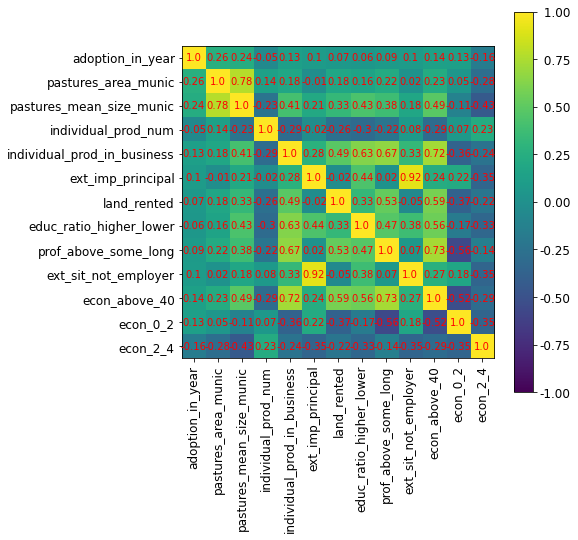

In [92]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + census_features_comb, label + census_features_comb], size=(7, 7))

In [93]:
sp_r_both_comb_attr.loc[['ext_imp_principal', 'ext_sit_not_employer']]

,spearman r only PCF,spearman r
ext_imp_principal,0.183,0.100
ext_sit_not_employer,0.149,0.103


Modification to TransformCensusFeaturesCombCorr: do not include ext_sit_not_employer

In [94]:
class TransformCensusFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, combine=True, keep_only_most_corr=False):
        self.combine = combine
        self.keep_only_most_corr = keep_only_most_corr

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # pastures_area_munic and mean_pastures_size_munic remain the same
        XX = X[['pastures_area_munic', 'pastures_mean_size_munic']]

        # individual_prod_num also kept
        XX = pd.concat([XX, X['individual_prod_num']], axis=1)

        # individual_prod_autonomous + individual_prod_in_business = 1 ->
        # can keep only the second (opp. correlation)
        XX = pd.concat([XX, X['individual_prod_in_business']], axis=1)

        # 'agr_time_partial' + 'agr_time_full' = 1. But both have really low 
        # correlation --> exluded
        
        # ext_imp_pricipal excluded since high correlation with 
        # ext_sit_not_employer/ext_sit_employed by others
        
        # keep land_rented
        XX = pd.concat([XX, X['land_rented']], axis=1)

        if self.combine and self.keep_only_most_corr:
            raise ValueError("Only one among the parameters 'combine' and"
                             "'keep_only_most_relevant' can be True")

        elif self.combine:
           # Education: group to have educ_3rd_cycle_or_higher
            feats_above_3rd_cycle = ['educ_basic_3rd_cycle',
                                     'educ_secondary_agr',
                                     'educ_secondary_not_agr',
                                     'educ_polyt_or_superior_agr',
                                     'educ_polyt_or_superior_not_agr']
            educ_above_basic = X[feats_above_3rd_cycle].sum(axis=1)
            educ_above_basic.name = 'educ_3rd_cycle_or_higher'
            XX = pd.concat([XX, educ_above_basic], axis=1)

            # Agricultural professional formation: group short_and_long and
            #above
            apf_feats_to_group = ['prof_long', 'prof_short_and_long',
                                  'prof_complete']
            apf_grouped = X[apf_feats_to_group].sum(axis=1)
            apf_grouped.name = 'prof_above_some_long'
            XX = pd.concat([XX, apf_grouped], axis=1)
            
            # External activity situation: group not employed (employer has a
            # low correlation)
            ext_sit_feats_not_empl = ['ext_sit_self_employed',
                                      'ext_sit_employed_by_others',
                                      'ext_sit_in_family']
            ext_sit_grouped = X[ext_sit_feats_not_empl].sum(axis=1)
            ext_sit_grouped.name = 'ext_sit_not_employer'
            XX = pd.concat([XX, ext_sit_grouped], axis=1)

            # Economic class: keep above 40 and 0-2, 2-4
            feats_econ_above_40 = ['econ_40_100', 'econ_above_100']
            econ_above_40 = X[feats_econ_above_40].sum(axis=1)
            econ_above_40.name = 'econ_above_40'
            XX = pd.concat([XX, econ_above_40, X['econ_0_2'], X['econ_2_4']], axis=1)            
            
        elif self.keep_only_most_corr:
            # Education
            educ_most_corr = 'educ_polyt_or_superior_agr'
            XX = pd.concat([XX, X[educ_most_corr]], axis=1)     

            # Agricultural professional formation
            apf_most_corr = 'prof_complete'
            XX = pd.concat([XX, X[apf_most_corr]], axis=1)

            # External activity situation
            eas_most_corr = 'ext_sit_employed_by_others'
            XX = pd.concat([XX, X[eas_most_corr]], axis=1)

            # Economic class: keep above 100 and 0-2, 2-4
            XX = pd.concat([XX, X['econ_above_100'], X['econ_0_2'], X['econ_2_4']], axis=1)

        else:
            raise ValueError("One between the parameters 'combine' and"
                             "'keep_only_most_relevant' has to be True")

        return XX

#### Adoption features

In [95]:
vif_comb_attr.loc[adoption_features]

,VIF
features,
adoption_pr_y_munic,2.365
tot_cumul_adoption_pr_y_munic,58.718
cumul_adoption_10_y_pr_y_munic,63.443
adoption_pr_y_neighbours_adj,6.680
tot_cumul_adoption_pr_y_neighbours_adj,229.129
cumul_adoption_10_y_pr_y_neighbours_adj,239.892
adoption_pr_y_neighbours_10km,13.000
tot_cumul_adoption_pr_y_neighbours_10km,447.273
cumul_adoption_10_y_pr_y_neighbours_10km,474.527


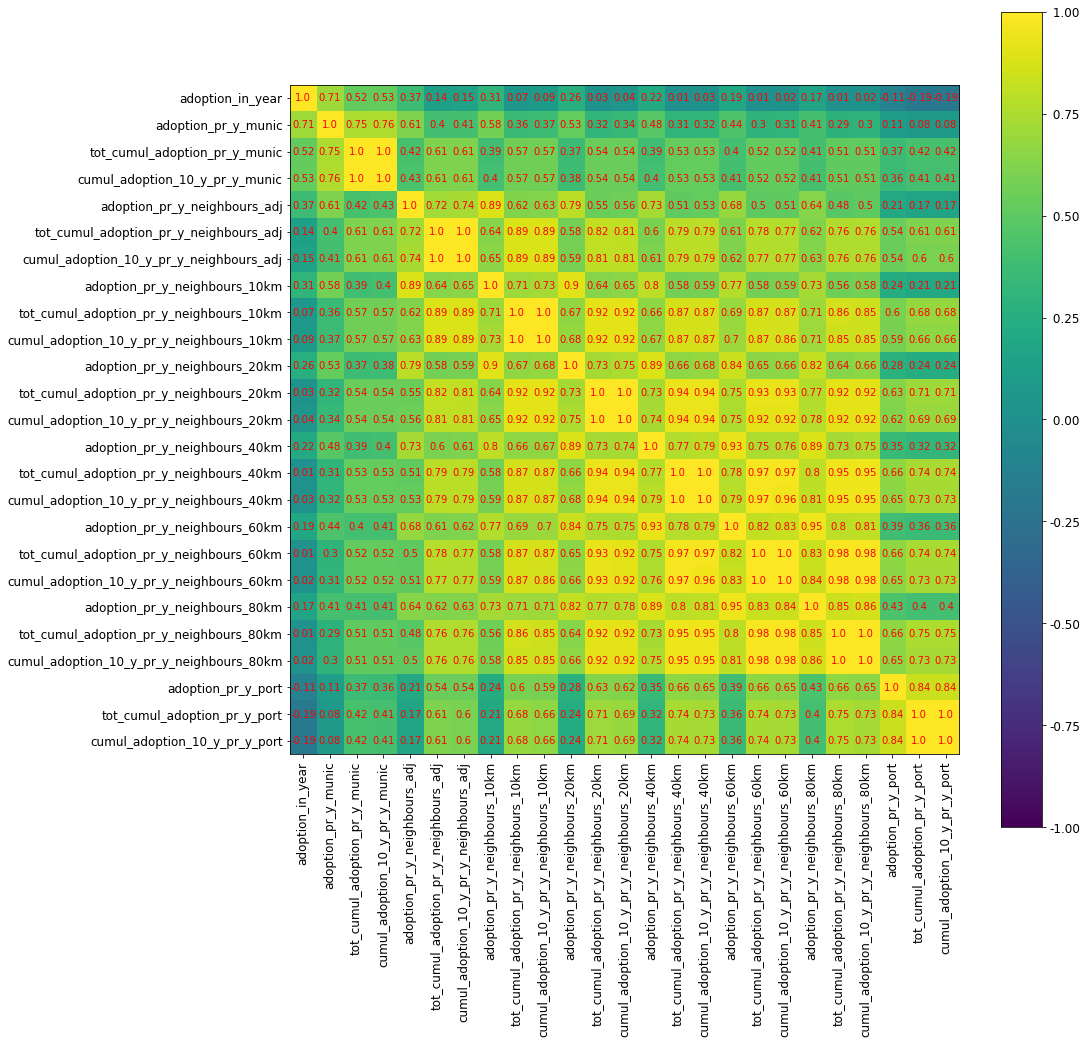

In [96]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + adoption_features, label + adoption_features], size=(15, 15))

In [97]:
sp_r_both_comb_attr.loc[adoption_features].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
adoption_pr_y_munic,0.617,0.713
adoption_pr_y_neighbours_adj,0.543,0.366
adoption_pr_y_neighbours_10km,0.527,0.309
adoption_pr_y_neighbours_20km,0.501,0.263
adoption_pr_y_neighbours_40km,0.489,0.223
tot_cumul_adoption_pr_y_munic,0.477,0.520
adoption_pr_y_neighbours_60km,0.472,0.193
cumul_adoption_10_y_pr_y_munic,0.467,0.531
adoption_pr_y_neighbours_80km,0.450,0.165
tot_cumul_adoption_pr_y_neighbours_adj,0.447,0.142


In [98]:
class TransformAdoptionFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        adoption_features = X.columns
        # All features referring to tot_cumul excluded (highly corr with 10_y, that are slighlty more correlated with adoption)
        
        # Excluded everything for neighbouring not adjacent, since adoption in prev_year and cumul_10_y too correlated
        
        # Definition of the ones to keep: municipality, adjacent and portugal not tot_cumul       
        feats_munic = [feat for feat in adoption_features if '_munic' in feat]
        feats_adj_neigh = [feat for feat in adoption_features if '_adj' in feat]
        feats_port = [feat for feat in adoption_features if '_port' in feat]
        
        feats_to_keep_all = feats_munic + feats_adj_neigh + feats_port
        feats_to_keep = [feat for feat in feats_to_keep_all if '10_y' not in feat]
        
        return X[feats_to_keep]

#### Soil and climate features

In [99]:
env_features = soil_features + climate_features

In [100]:
prec_features = [feat for feat in climate_features if '_prec' in feat]

In [101]:
sp_r_both_comb_attr.loc[prec_features].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
cons_days_no_prec_average_munic,0.603,0.267
cons_days_no_prec_pr_y_munic,0.445,0.182
days_no_prec_average_munic,0.620,0.182
days_no_prec_pr_y_munic,0.275,0.114
av_prec_sum_pr_y_munic,-0.307,-0.108
av_prec_sum_average_munic,-0.560,-0.121


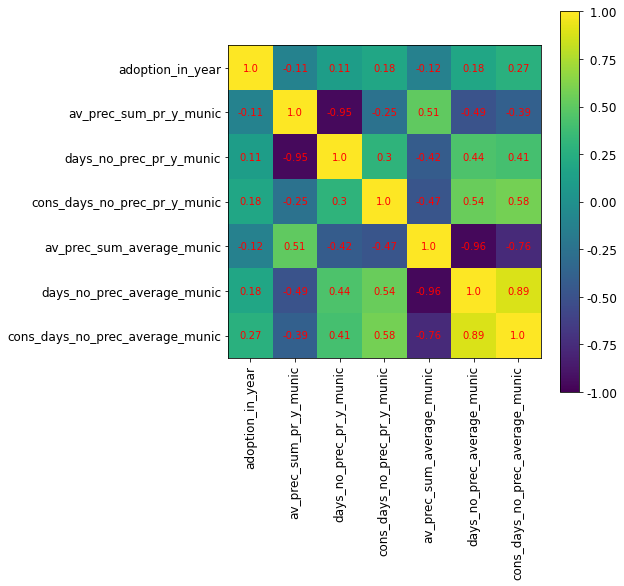

In [102]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + prec_features, label + prec_features], size=(7, 7))

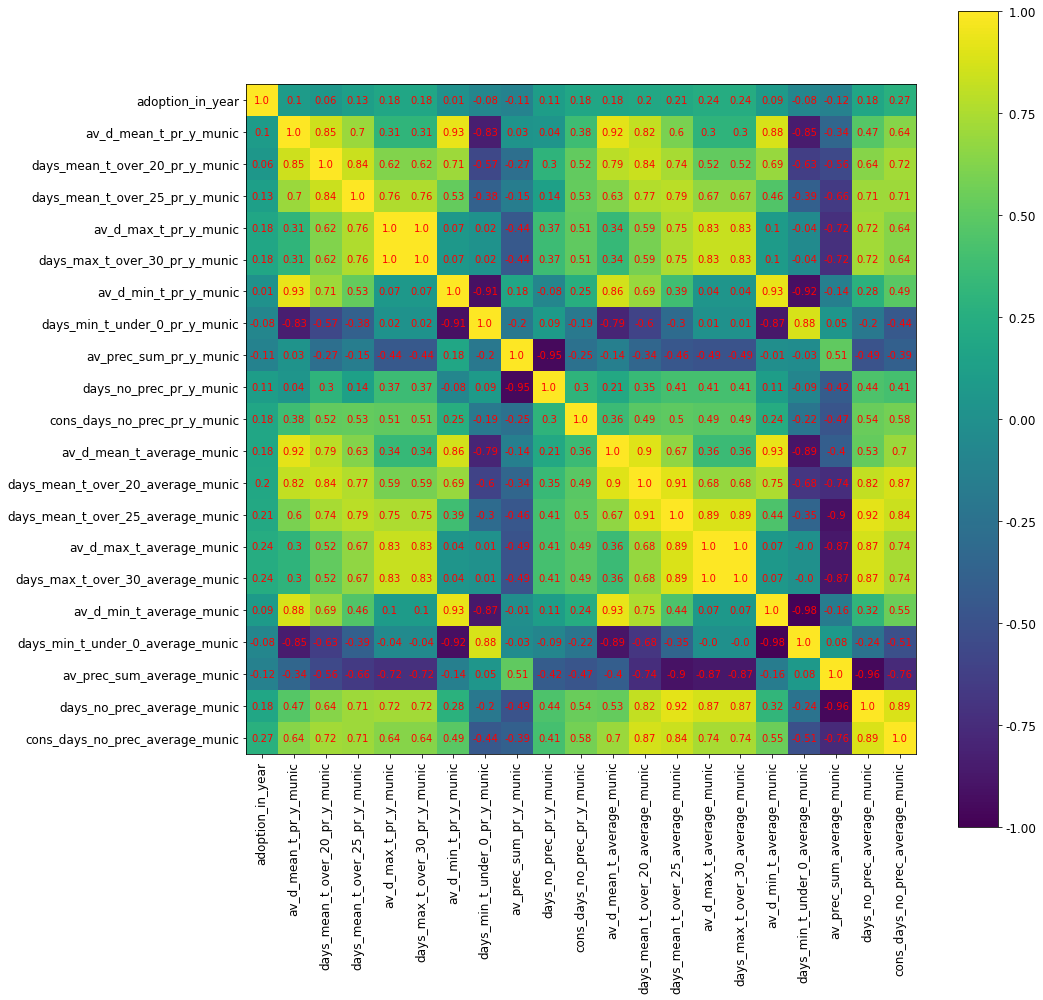

In [103]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + climate_features, label + climate_features], size=(15, 15))

In [104]:
max_t_feats = [feat for feat in climate_features if '_max_t' in feat]
spearman_results_both.loc[max_t_feats ]

,spearman r only PCF,spearman r
av_d_max_t_pr_y_munic,0.528,0.185
days_max_t_over_30_pr_y_munic,0.528,0.185
av_d_max_t_average_munic,0.601,0.240
days_max_t_over_30_average_munic,0.601,0.240


In [105]:
class TransformClimateFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        climate_features = X.columns
        
        # All previous years ones excluded since the averages are more correlated!
        
        # Min temp: excluded all since high correlation with av_d_mean_t and
        # low with the target variable
        # Max temp: can keep only one of the two since perfectly correlated,
        # so exluded both days_max_t_over_30
        # Mean temp: excluded days_mean_t_over_20/25 since only one of these
        # kept and av_d_mean_t less correlated with max_t 
        # Prec: exclude both av_prec_sum_pr_y (too correlated with max_t) and
        # days_no
        
        # Definition of the ones to keep.
        feats_mean_t = [feat for feat in climate_features
                        if 'av_d_mean_t_average' in feat]
        feats_max_t = [feat for feat in climate_features
                        if 'av_d_max_t_average' in feat]
        # Precipitation features: keep only cons_days_no_prec
        feats_prec = [feat for feat in climate_features
                      if 'cons_days_no_prec_average' in feat]
        
        feats_to_keep = feats_mean_t + feats_max_t + feats_prec
        
        return X[feats_to_keep]

In [106]:
vif_comb_attr.loc[soil_features]

,VIF
features,
CaCO3_mean_munic,8.871
CN_mean_munic,14.599
N_mean_munic,4.597
P_mean_munic,4.385
pH_mean_munic,25.260


In [107]:
feats_mean_t = [feat for feat in climate_features if 'av_d_mean_t' in feat]
feats_max_t = [feat for feat in climate_features if 'av_d_max_t' in feat]
feats_prec = [feat for feat in climate_features if 'cons_days_no_prec' in feat]
climate_features_kept = feats_mean_t + feats_max_t + feats_prec

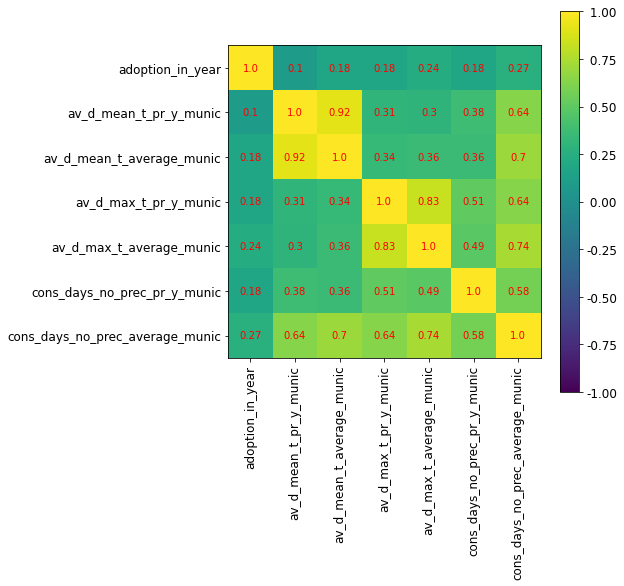

In [108]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + climate_features_kept, label + climate_features_kept], size=(7, 7))

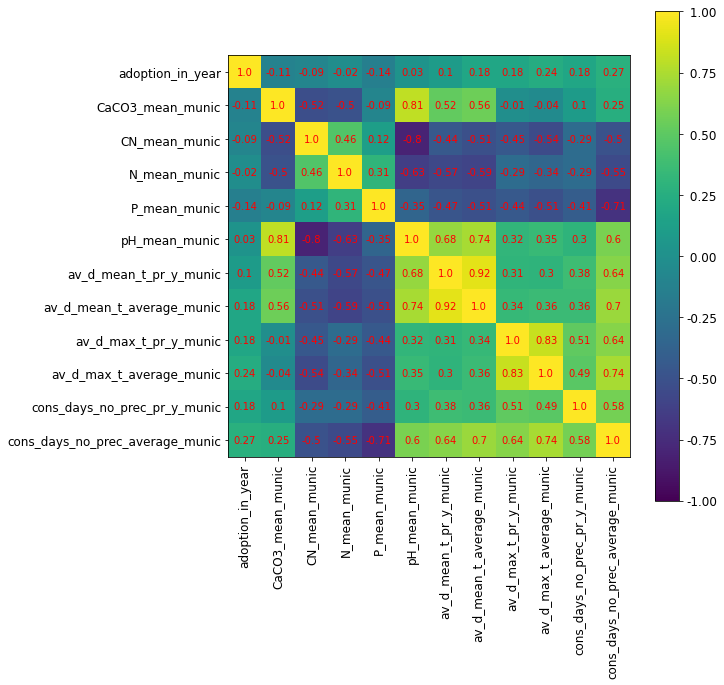

In [109]:
feats = label + soil_features + climate_features_kept
plot_correlation_heatmap(corr_matrix_comb_attr.loc[feats, feats], size=(9, 9))

In [110]:
spearman_results_both.loc[soil_features]

,spearman r only PCF,spearman r
CaCO3_mean_munic,0.056,-0.114
CN_mean_munic,-0.530,-0.088
N_mean_munic,-0.218,-0.024
P_mean_munic,-0.356,-0.137
pH_mean_munic,0.387,0.035


In [111]:
class TransformSoilFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        soil_features = X.columns

        # 'pH_mean_munic' excluded since high correlation with NC and CaCO3 (also with av_d_mean_t_average_munic)
        
        # Definition of the ones to keep. 
        feats_to_keep = [feat for feat in soil_features if feat != 'pH_mean_munic']

        return X[feats_to_keep]

#### Economic features

### Create of a dataset with these transformations

In [112]:
# Get features names
feat_lists = [census_features, adoption_features, climate_features, soil_features]
transformers = [TransformCensusFeatures(), TransformAdoptionFeatures(), TransformClimateFeatures(), TransformSoilFeatures()]

features_red = []
for f, t in zip(feat_lists, transformers):
    features = t.transform(dataset[f]).columns.to_list()
    features_red = features_red + features

In [113]:
len(features_red)

24

In [114]:
from sklearn.compose import ColumnTransformer

full_dataset_transformation = ColumnTransformer([
    ('census', TransformCensusFeatures(), census_features),
    ('adoption', TransformAdoptionFeatures(), adoption_features),
    ('climate', TransformClimateFeatures(), climate_features),
    ('soil', TransformSoilFeatures(), soil_features)
    #('economic', TransformEconomicFeatures(), economic_features)
],
    remainder='drop')

In [115]:
dataset_comb_attr_red = full_dataset_transformation.fit_transform(dataset)
dataset_comb_attr_red = pd.DataFrame(dataset_comb_attr_red, columns=features_red)
dataset_comb_attr_red.insert(0, 'adoption_in_year', dataset[label].values)

In [116]:
dataset_comb_attr_red

,adoption_in_year,pastures_area_munic,pastures_mean_size_munic,individual_prod_num,individual_prod_in_business,land_rented,educ_3rd_cycle_or_higher,prof_above_some_long,ext_sit_not_employer,econ_above_40,...,tot_cumul_adoption_pr_y_neighbours_adj,adoption_pr_y_port,tot_cumul_adoption_pr_y_port,av_d_mean_t_average_munic,av_d_max_t_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic
0,1,1290.000,15.000,2103.000,0.017,0.034,0.140,0.019,0.238,0.027,...,0.000,0.000,0.000,16.596,66.535,68.951,11.578,15.374,1.327,6.903
1,1,1290.000,15.000,2103.000,0.017,0.034,0.140,0.019,0.238,0.027,...,0.003,0.001,0.001,16.596,66.535,68.951,11.578,15.374,1.327,6.903
2,1,1290.000,15.000,2103.000,0.017,0.034,0.140,0.019,0.238,0.027,...,0.005,0.002,0.003,16.596,66.535,68.951,11.578,15.374,1.327,6.903
3,1,1290.000,15.000,2103.000,0.017,0.034,0.140,0.019,0.238,0.027,...,0.012,0.003,0.006,16.596,66.535,68.951,11.578,15.374,1.327,6.903
4,1,1290.000,15.000,2103.000,0.017,0.034,0.140,0.019,0.238,0.027,...,0.018,0.003,0.009,16.596,66.535,68.951,11.578,15.374,1.327,6.903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,1,73.000,3.042,1007.000,0.036,0.238,0.056,0.095,0.321,0.113,...,0.033,0.008,0.058,16.590,31.042,59.396,42.810,13.803,1.055,16.927
4399,0,73.000,3.042,1007.000,0.036,0.238,0.056,0.095,0.321,0.113,...,0.034,0.005,0.059,16.590,31.042,59.396,42.810,13.803,1.055,16.927
4400,0,73.000,3.042,1007.000,0.036,0.238,0.056,0.095,0.321,0.113,...,0.034,0.010,0.066,16.590,31.042,59.396,42.810,13.803,1.055,16.927
4401,0,73.000,3.042,1007.000,0.036,0.238,0.056,0.095,0.321,0.113,...,0.034,0.012,0.075,16.590,31.042,59.396,42.810,13.803,1.055,16.927


### Reassess VIF

In [117]:
vif_comb_attr_red = vif(dataset_comb_attr_red)

In [118]:
vif_comb_attr_red.sort_values('VIF', ascending=False)

,VIF
features,
Intercept,1017.054
av_d_max_t_average_munic,8.825
cons_days_no_prec_average_munic,7.933
CN_mean_munic,5.810
econ_above_40,4.498
av_d_mean_t_average_munic,4.311
pastures_mean_size_munic,3.740
tot_cumul_adoption_pr_y_port,3.719
CaCO3_mean_munic,3.664


## Metrics for final set of features

In [119]:
d = pd.DataFrame(index=features_red)

In [120]:
d['VIF'] = vif_comb_attr_red

In [121]:
dataset_comb_attr_red_PCF = pd.DataFrame(dataset_comb_attr_red.values, index=dataset_original.index,
                                        columns=dataset_comb_attr_red.columns).loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [122]:
d2 = get_spearman_both(features_red, dataset_comb_attr_red, dataset_comb_attr_red_PCF)

In [123]:
d3 = pd.concat([d2, d], axis=1)

In [124]:
d3

,spearman r only PCF,spearman r,VIF
pastures_area_munic,0.609,0.258,2.440
pastures_mean_size_munic,0.613,0.237,3.740
individual_prod_num,-0.153,-0.051,1.573
individual_prod_in_business,0.362,0.130,2.196
land_rented,0.363,0.066,1.958
educ_3rd_cycle_or_higher,0.462,0.054,3.170
prof_above_some_long,0.344,0.088,3.434
ext_sit_not_employer,0.149,0.103,1.927
econ_above_40,0.453,0.138,4.498
econ_0_2,0.030,0.128,1.838
